# Exploring parameters

#### density plots, post predictive checks etc.

In [1]:
%load_ext autoreload
%autoreload 2
import os.path as op
import tempfile

import matplotlib.pyplot as plt


import hnn_core
from hnn_core import simulate_dipole, jones_2009_model
from hnn_core.viz import plot_dipole


import sys
sys.path.append('../code/')
sys.path.append('../code/utils/')
#sys.path.append('../code/sbi/')
#sys.path.append('../../results_cluster/')


import numpy as np
import torch

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt


import os

work_dir = '/home/ubuntu/sbi_for_eeg_data/code/'

os.chdir(work_dir)

#from utils.plot import cov, compare_vars, plot_varchanges
#from utils.plot import compare_KLs, plot_KLs
#from sbi.inference import potentials
import utils.sbi_modulated_functions

# sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi

from sbi.analysis import conditional_pairplot, conditional_corrcoeff



# import the summary statistics that you want to investigate
from summary_features.calculate_summary_features import calculate_summary_statistics_alternative as alternative_sumstats
from summary_features.calculate_summary_features import calculate_summary_stats_temporal as temporal_sumstats
from summary_features.calculate_summary_features import calculate_summary_stats_number as number_sumstats
from summary_features.calculate_summary_features import calculate_summary_stats_temporal


In [2]:
print(torch.__version__)

1.9.1+cu102


In [3]:
## defining neuronal network model

num_params = 6

from utils.simulation_wrapper import set_network_default, SimulationWrapper
sim_wrapper = SimulationWrapper(num_params, noise=False)


In [20]:
from utils import inference

import pickle
from data_load_writer import *
from data_load_writer import load_from_file as lf

import os

work_dir = '/home/ubuntu/'

os.chdir(work_dir)



import os

print(os.getcwd())



file = 'toy_example_mdn_08_04_lesser_ratio'


print(os.getcwd())

os.chdir('results/{}'.format(file))


print(os.getcwd())
  



/home/ubuntu
/home/ubuntu
/home/ubuntu/results/toy_example_mdn_08_04_lesser_ratio


In [21]:
def Gaussian(thetas, normal_noise=1):
    
    gauss_list = []
    
    for theta in thetas:
    
        mu, sigma = theta, normal_noise # mean and standard deviation

        s = np.random.normal(mu, sigma, 1)
    
        
        gauss_list.append(s[0])
        
    gauss_obs = torch.tensor(gauss_list)
    
    return gauss_obs
    



In [22]:
list_collection = torch.load('list_collection.pt')
list_collection_inc = torch.load('list_collection_inc.pt')

In [23]:
true_thetas = torch.tensor([[3.0, 6.0, 20.0, 10.0, 90.0, 55.0, 27.0, 27.0, 4.0, 70.0, 5.0, 66.0, 99.0, 40.0, 45.0]])
parameter_names = ['t1', 't2', 't3', 't4', 't5', 't6', 't7', 't8', 't9', 't10', 't11', 't12', 't13', 't14', 't15']

prior_max = [100.0] * 15
prior_min = [1.0] * 15

prior = utils.torchutils.BoxUniform(low=prior_min, high = prior_max)

samples_prior = prior.sample((10000,))

simulator_stats, prior = prepare_for_sbi(Gaussian, prior)

In [24]:
samples_prior_list = samples_prior.unsqueeze(0)

In [25]:
samples_prior_list[0].shape

torch.Size([10000, 15])

In [26]:
thetas = inference.run_only_sim(samples_prior_list, simulation_wrapper = simulator_stats, num_workers=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s finished


In [27]:
def KL_Gauss(X, Y):
    
    sample_x = X.sample((1000,))
    mu_x = torch.mean(sample_x, dim=0)
    var_x = torch.std(sample_x, dim=0)

    var_y = Y.stddev

    mu_y = Y.mean
    
    
    return torch.mean(np.log(var_y/var_x) + (var_x**2 + (mu_x - mu_y)**2)/(2*var_y**2) -(1/2)), var_x, mu_x


def calc_KL_1d(X, Y):
    
    sample_x = X.sample((1000,))
    mu_x = torch.mean(sample_x, dim=0)
    var_x = torch.std(sample_x, dim=0)
    
    print(var_x)
    print(mu_x)


    var_y = Y.stddev

    mu_y = Y.mean
    
    print(mu_y)
    print(var_y)
    
    print(np.log(var_y/var_x) + (var_x**2 + (mu_x - mu_y)**2)/(2*var_y**2) -(1/2))
    
    return np.log(var_y/var_x) + (var_x**2 + (mu_x - mu_y)**2)/(2*var_y**2) -(1/2)


# calculate the jensen-shanon divergence
def js_divergence(p, q):
    m = 0.5 * (p + q)
    return 0.5 * kl_divergence(p, m) + 0.5 * kl_divergence(q, m)

In [28]:

analytic = torch.distributions.normal.Normal(true_thetas, 1)


overall_snpe_list = []

variance_list_snpe = []

mean_list_snpe = []


## for round
for posterior_snpe_list in list_collection:
    
    KL_snpe = []
    KL_snpe_1d = []
    
    
    ## for number of simulations
    for posterior_snpe in posterior_snpe_list:


        #KL = KLdivergence(posterior_snpe, sample_y)
        KL, var_x, mu_x = KL_Gauss(posterior_snpe, analytic)
        
        variance_list_snpe.append(var_x)
        
        mean_list_snpe.append(mu_x)


        KL_1d = calc_KL_1d(posterior_snpe, analytic)

        KL_snpe_1d.append(KL_1d)

        #KL_snpe_sum.append(sum_KL)

        KL_snpe.append(KL)
        
    overall_snpe_list.append(KL_snpe)


    
    

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([4.8537, 5.5017, 5.7614, 3.7133, 3.8186, 9.3671, 8.2499, 5.3581, 3.6383,
        8.3549, 2.1150, 4.2641, 2.0576, 8.0975, 4.1035])
tensor([11.0979, 24.6152, 29.3656,  8.7576, 72.0483, 52.1640, 36.5574, 43.4761,
         7.7979, 75.3220,  3.8299, 48.6396, 96.6837, 27.2754, 36.6082])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 42.4875, 186.1927,  58.2025,   5.8542, 166.5824,  45.1551,  77.0923,
         147.9068,  12.0389,  46.4411,   1.6720, 157.8332,   3.5779, 111.1509,
          41.7186]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([ 5.2520,  4.8270,  6.2887, 11.6668,  5.8605,  6.4379,  4.0490,  5.5789,
         4.6801,  7.1114,  5.9643,  5.9971,  3.9238,  4.8537,  6.3455])
tensor([12.1083, 11.2831, 46.4619, 32.3008, 91.2657, 59.0969, 10.4824, 35.6959,
        14.8553, 60.3930, 19.9511, 77.9186, 95.3859, 41.6977, 47.1367])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 53.1135,  23.5311, 367.5517, 313.7636,  15.7053,  26.7535, 142.7141,
          51.1520,  67.8267,  68.9714, 127.2676,  86.7177,  12.3621,  11.1407,
          20.0676]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([9.1963, 5.8918, 4.3909, 4.9517, 7.8271, 3.3981, 8.8552, 4.4494, 9.7105,
        6.4100, 3.8398, 2.9461, 3.0821, 6.5104, 8.3597])
tensor([30.5579, 28.7735, 36.4101, 24.5411, 60.2261, 59.0617, 50.4155, 33.4566,
        43.7148, 54.7038, 21.1269, 50.6420, 90.8654, 22.5468, 81.0352])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[419.2851, 274.3981, 142.3066, 115.8810, 471.3179,  12.2992, 310.6686,
          28.7497, 833.0073, 135.1722, 135.5645, 120.6934,  36.2095, 171.1260,
         681.5861]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([1.7527, 1.6632, 4.3659, 1.2881, 3.0719, 2.3594, 1.5367, 2.3573, 2.2108,
        0.9044, 1.6198, 1.4948, 3.2611, 2.8950, 4.1002])
tensor([ 4.7417,  3.4720, 22.3167,  8.9217, 92.3441, 53.4659, 27.0358, 27.0039,
         4.7640, 68.5861,  3.5660, 64.8851, 95.1004, 40.4295, 42.1150])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 1.9915,  3.5697, 10.2403,  0.6578,  5.8433,  2.6016,  0.2518,  1.4208,
          1.4423,  1.0090,  1.3577,  0.8367, 11.2385,  2.7198, 10.6564]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([5.1329, 7.8776, 7.6278, 6.0282, 5.1168, 1.7207, 1.6567, 3.2076, 4.0339,
        3.5084, 2.8118, 2.9945, 4.7190, 4.7573, 7.0811])
tensor([16.5450, 34.0114, 17.9778, 21.5558, 88.7327, 51.6708, 28.0442, 17.5998,
         8.9081, 65.3879, 15.9131, 71.7803, 89.7352, 38.9137, 36.1805])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[102.7709, 420.7834,  28.6043,  82.6416,  11.7611,   5.9795,   0.9127,
          47.6605,  18.2861,  15.0352,  61.9675,  19.5930,  52.0014,   9.8462,
          61.5050]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([2.5012, 4.2816, 7.6062, 2.0658, 3.0469, 1.7223, 2.1076, 3.6269, 1.4048,
        2.3357, 1.3469, 3.1706, 3.0662, 2.1490, 8.6351])
tensor([ 8.7510, 13.5943, 35.1506, 14.2414, 88.1667, 52.4537, 29.7406, 33.4456,
         2.8859, 64.5530,  6.9935, 58.7036, 93.8746, 35.3428, 28.4548])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 18.2480,  36.0488, 141.1683,   9.9030,   4.7082,   3.6812,   4.7310,
          25.5620,   0.7674,  16.2144,   2.0962,  29.9911,  16.2151,  11.8887,
         171.4978]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([4.6028, 5.9294, 6.0636, 5.0099, 7.5974, 5.9489, 4.2600, 4.1611, 5.2476,
        6.2334, 3.9970, 6.3845, 5.2052, 3.3031, 8.1332])
tensor([ 9.2951, 16.9268, 11.0885, 14.7856, 64.8251, 44.4445, 24.5496, 25.9692,
         8.6683, 85.8244,  8.0851, 81.2945, 82.3004, 36.9101, 34.4941])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 28.3807,  74.9961,  55.7887,  21.8893, 343.2198,  71.1208,  10.1268,
           7.2629,  22.5075, 142.3038,  10.8614, 134.9881, 150.8358,   8.5340,
          85.6660]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([4.2825, 5.5027, 4.4959, 5.0713, 5.1476, 6.9230, 5.2709, 5.6985, 4.2481,
        4.3845, 5.7831, 7.0407, 6.9780, 5.8645, 7.0760])
tensor([17.1064, 13.2785, 13.1214, 21.4160, 90.8921, 31.7219, 12.6374, 42.5331,
        16.3941, 67.2835, 12.0664, 44.3447, 76.3259, 35.2942, 18.9376])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[106.7099,  39.4230,  31.7612,  75.8976,  11.5085, 292.4641, 114.8709,
         134.6344,  83.8835,  11.3237,  39.4340, 256.8096, 278.9603,  25.9996,
         362.2024]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([7.7112, 8.4104, 3.8298, 3.9659, 5.7632, 5.2271, 2.3454, 6.0365, 9.3465,
        4.0622, 7.1070, 5.5340, 3.1878, 6.2673, 7.5406])
tensor([15.0004, 20.9240, 17.6872,  9.4646, 83.7189, 61.4925, 15.4409, 41.2213,
        27.0355, 66.9341, 24.3825, 89.6014, 94.5586, 47.3751, 66.0856])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 99.1939, 144.1005,   8.1653,   6.1299,  34.0816,  32.5837,  68.2042,
         117.0443, 306.2603,  11.0490, 210.6350, 291.6141,  13.2845,  44.4998,
         248.2120]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([5.3856, 3.3262, 4.3841, 4.2820, 3.0050, 3.2854, 4.8302, 2.1035, 4.2159,
        5.1323, 2.1624, 2.9087, 3.3610, 8.2562, 4.6262])
tensor([ 9.1391,  5.8383,  7.0641, 16.1349, 92.5193, 54.3587, 32.8586, 28.1762,
        10.2330, 53.5031,  8.0989, 57.5905, 90.3299, 22.7643, 42.5496])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 31.1628,   3.8431,  91.3004,  26.0319,   6.0882,   3.9130,  26.7520,
           1.6604,  26.3734, 147.1087,   5.8682,  38.0221,  41.5211, 180.0067,
          11.6714]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([1.3642, 3.7080, 1.9914, 2.6973, 1.7885, 2.2362, 4.4184, 3.8045, 1.4546,
        2.1437, 1.7789, 0.8099, 1.7604, 2.0783, 6.8072])
tensor([ 3.1240,  7.5659, 19.5243,  7.9653, 90.4756, 53.4146, 21.9143, 24.1792,
         5.2680, 67.3865,  6.4454, 63.9233, 97.4668, 37.5437, 52.5920])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 0.1276,  6.2901,  0.9071,  4.2155,  0.6311,  2.4523, 20.7075,  9.3795,
          0.9871,  4.4504,  1.5507,  2.1952,  1.6592,  3.9450, 49.5707]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([ 2.5208,  6.7223, 10.9275,  6.3993,  5.0315,  3.8341,  2.0611,  1.1731,
        11.8183,  1.9041,  2.2299,  3.3993,  1.2827,  2.2868,  3.2340])
tensor([11.9853, 19.6480, 19.6079, 19.9198, 81.7967, 52.7543, 28.0053, 25.4213,
        27.8663, 64.3497,  8.2603, 71.9470, 98.2627, 34.9051, 34.2482])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[4.2121e+01, 1.1332e+02, 5.6890e+01, 6.7321e+01, 4.4190e+01, 8.0277e+00,
         1.4061e+00, 1.2746e+00, 3.5167e+02, 1.6632e+01, 6.4992e+00, 2.1738e+01,
         3.4553e-01, 1.4266e+01, 6.1357e+01]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([3.9422, 7.6880, 5.7232, 3.8967, 4.5395, 6.3593, 5.3078, 4.4752, 4.1637,
        8.9869, 1.3021, 6.0728, 6.0471, 4.0612, 5.4480])
tensor([ 8.5529, 22.0216, 13.7424, 15.0870, 90.2176, 54.9653, 11.1261, 33.6764,
        11.1330, 70.4846,  2.5033, 59.8249, 81.4521, 50.0410, 47.1424])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 21.3158, 155.3594,  33.7123,  18.6710,   8.3145,  17.8707, 137.9078,
          30.3027,  32.1818,  37.8038,   3.2004,  35.2019, 169.9477,  56.7556,
          14.9399]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([1.2173, 2.9844, 4.8093, 1.9506, 1.2181, 2.2119, 1.4819, 3.6009, 1.7624,
        1.8553, 1.1229, 1.6650, 1.7337, 0.7112, 1.6536])
tensor([ 2.4002,  7.8279, 17.0342, 13.2380, 88.2420, 55.8675, 26.2680, 23.8656,
         8.3451, 65.9965,  2.2935, 64.1131, 97.6637, 40.8704, 48.3328])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 0.2242,  4.5307, 13.8924,  5.9765,  1.5899,  1.5287,  0.4726,  9.6143,
          9.9265,  8.6170,  3.6772,  2.1565,  1.3454,  0.4725,  5.9179]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([0.9453, 2.0314, 5.2297, 3.9961, 2.3682, 4.6644, 5.2015, 4.3080, 3.8745,
        0.9228, 4.9650, 2.4049, 2.5819, 2.4467, 5.2275])
tensor([ 2.9518,  6.5854, 19.9636,  9.5977, 96.4357, 65.3842, 19.8803, 36.5382,
        14.4442, 71.5690, 17.5467, 58.5013, 95.8591, 39.1209, 37.0521])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[4.2040e-03, 1.0259e+00, 1.1521e+01, 6.1798e+00, 2.2151e+01, 6.2754e+01,
         3.6724e+01, 5.2808e+01, 6.0192e+01, 1.2371e+00, 8.8932e+01, 2.9629e+01,
         6.8171e+00, 1.9848e+00, 4.3094e+01]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

                        constant for `log_prob()`. However, only
                        0% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 994 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

                        constant for `log_prob()`. However, only
                        0% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 998 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


tensor([5.2530, 5.2935, 1.3139, 5.3051, 5.0660, 1.8159, 6.1081, 3.3056, 2.7219,
        8.8717, 1.0216, 2.9535, 2.6303, 6.0435, 5.0865])
tensor([ 8.0821, 18.1383, 21.8904, 23.4444, 90.8517, 57.1346, 36.7522, 18.1079,
         6.3157, 46.5055,  2.2134, 57.5337, 98.5256, 54.1559, 53.7465])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 24.5517,  85.5139,   1.8770, 102.2801,  11.0726,   2.8305,  63.8971,
          43.3027,   4.8842, 312.6673,   3.8829,  38.6178,   2.1046, 116.1580,
          49.0606]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([0.7779, 1.3215, 2.3781, 0.2809, 3.4456, 4.2487, 0.7139, 1.1470, 0.2105,
        0.6714, 0.6540, 0.6521, 0.9587, 0.6920, 0.9452])
tensor([ 2.4442,  5.3632, 20.4354, 10.0440, 91.5326, 55.9368, 25.9942, 28.4042,
         5.7526, 68.7849,  5.6826, 64.1547, 98.6219, 38.5904, 45.7537])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[0.2082, 0.2972, 1.5561, 0.8101, 5.3734, 7.5177, 0.5977, 1.0065, 2.6161,
         0.8620, 0.3714, 1.8428, 0.0732, 1.1010, 0.2871]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([ 1.0219,  1.7001,  3.8716,  2.2238,  0.7782,  2.6521,  0.9671,  2.9770,
         5.6941,  0.9826,  0.6391,  0.5600,  6.1039,  5.7616, 11.0178])
tensor([ 2.3422,  5.9411, 25.0128,  7.9613, 91.1758, 52.6110, 25.1315, 31.3009,
        13.3136, 69.4850,  4.4725, 64.7007, 91.6130, 48.7328, 60.3774])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[2.1680e-01, 4.1623e-01, 1.8205e+01, 3.2514e+00, 7.4487e-01, 4.8951e+00,
         1.7467e+00, 1.2090e+01, 5.7343e+01, 1.3292e-01, 2.9109e-01, 1.0807e+00,
         4.3604e+01, 5.2478e+01, 1.7603e+02]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([ 4.2792,  2.5635,  6.3692,  6.6208,  6.6161,  7.7492, 13.9976,  5.8253,
         2.6498,  6.0766,  4.4300,  4.6960, 10.5055,  9.1100,  6.0349])
tensor([ 9.3991,  4.0129, 31.7453, 19.9616, 82.5420, 70.1908, 42.8509, 10.9897,
         4.1389, 63.2747,  7.1693, 60.0908, 70.1764, 25.4462, 42.7991])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 27.6765,   3.8187,  86.9082,  69.1438,  47.3077, 142.8572, 220.4539,
         142.8706,   2.0459,  38.7728,  10.1770,  26.4385, 467.7320, 144.6939,
          18.3343]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([2.2035, 3.4092, 1.8046, 2.5721, 2.9881, 4.0747, 0.9986, 2.1418, 2.0876,
        2.2960, 1.6176, 1.9876, 2.3118, 4.4361, 3.5361])
tensor([ 5.4492,  7.0300, 17.3145,  5.2829, 86.4582, 50.4013, 26.0226, 24.5874,
         4.4719, 72.0142,  3.6125, 63.5396, 97.1486, 47.4391, 40.2851])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 4.1371,  4.6152,  4.1439, 12.9888,  9.1420, 16.9708,  0.4777,  3.9425,
          1.0544,  3.3333,  1.2900,  3.8151,  3.0480, 35.5202, 15.6040]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([1.7936, 2.3279, 3.2733, 3.3991, 2.5468, 4.2319, 2.6433, 4.0280, 6.6735,
        3.7401, 3.4774, 5.7707, 1.9233, 5.5275, 3.5436])
tensor([ 4.8902,  4.4363, 24.0004,  7.4505, 94.6623, 48.7000, 21.2212, 19.7944,
        16.3564, 76.0132,  8.0564, 68.5299, 97.1607, 48.9379, 50.5285])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 2.3107,  2.5872, 11.6728,  7.3034, 12.6766, 26.8567, 18.7184, 32.1794,
         96.2100, 23.2547,  8.9708, 17.5981,  2.3871, 53.0101, 19.7958]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

                        constant for `log_prob()`. However, only
                        1% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 691 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([1.0879, 3.0486, 2.1664, 1.2044, 0.6101, 1.5728, 1.1177, 1.6206, 1.1946,
        0.7485, 1.2174, 0.8203, 2.0902, 2.4631, 1.9176])
tensor([ 2.5559,  8.3382, 22.6978,  9.4343, 90.5723, 57.9723, 24.2570, 27.5049,
         6.8385, 68.7515,  3.2961, 65.1709, 96.9527, 41.2950, 47.3713])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[0.1061, 5.7658, 4.7127, 0.1993, 0.3440, 4.7012, 3.7753, 0.4578, 4.0643,
         0.8492, 1.4960, 0.3782, 3.0430, 2.4707, 3.4990]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([3.5369, 1.2836, 5.0564, 3.3903, 2.3256, 2.1087, 2.8364, 2.8737, 3.9882,
        3.3219, 2.5158, 4.7017, 1.8342, 2.4753, 2.0316])
tensor([ 7.1126,  6.1480, 19.0040,  8.1540, 96.2787, 54.1803, 26.8719, 22.1012,
         8.1540, 69.8839,  5.9616, 60.8874, 97.0192, 38.1697, 47.6277])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[12.9483,  0.0851, 11.1589,  5.7302, 21.0710,  1.3133,  2.4883, 14.5724,
         14.6972,  3.8236,  2.2043, 22.0745,  2.5374,  3.3321,  4.3072]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([0.2922, 0.3075, 3.0513, 0.5648, 0.5780, 0.5243, 0.2668, 0.8421, 0.3613,
        0.2467, 0.7193, 3.4348, 3.4581, 2.2253, 2.9066])
tensor([ 4.1997,  5.0287, 27.8618, 10.8686, 89.7939, 54.9659, 25.3836, 28.8715,
         6.2941, 69.5026,  6.2823, 56.4760, 91.5929, 45.0940, 38.5379])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 1.4926,  1.1983, 33.9437,  0.6080,  0.2364,  0.2837,  2.1634,  1.7777,
          3.2148,  1.0538,  0.9103, 49.5186, 31.6713, 14.1504, 23.5363]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([ 4.6563, 11.3562,  4.7217,  4.2501, 12.6494,  4.5353,  9.2457,  9.2173,
        13.3436,  7.4009,  9.3337, 10.2628,  7.3907,  7.4932,  7.8431])
tensor([ 8.5493, 41.9406, 25.5507,  6.4171, 51.7782, 73.5870, 23.2842, 45.0297,
        42.1777, 87.8325, 19.4901, 49.7313, 84.4092, 27.7312, 62.8382])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 24.1995, 707.4158,  24.5003,  13.5032, 807.4197, 181.0113,  46.9210,
         202.2938, 814.7028, 183.8830, 145.8061, 182.1697, 131.2575, 100.8220,
         187.2987]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([1.0659, 3.0079, 4.2325, 4.3905, 8.0482, 3.0953, 4.2169, 1.7335, 2.0761,
        4.9389, 2.1593, 4.4903, 1.4065, 5.9796, 3.4986])
tensor([ 2.2747,  5.2603, 27.2661,  9.7339, 73.2596, 62.3010, 14.9032, 29.9339,
         4.1085, 69.5348,  5.9789, 70.8926, 97.8758, 39.9988, 52.8567])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[  0.2672,   3.1961,  33.4120,   7.6944, 169.9219,  29.8129,  80.1184,
           4.7564,   0.9306,  10.2074,   1.5406,  20.0483,   0.7800,  15.5895,
          35.2316]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([2.0014, 1.8612, 2.2979, 2.5701, 1.8157, 2.4396, 1.6683, 2.8649, 4.1885,
        2.6201, 1.6916, 2.8987, 1.3925, 3.1927, 2.2404])
tensor([ 4.1732,  6.4539, 18.1356,  4.7441, 91.2312, 54.9516, 25.9185, 27.8863,
        11.7072, 72.1032,  4.6517, 59.5786, 97.7095, 35.2208, 49.5991])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 1.4972,  0.7138,  3.0461, 15.6713,  1.3098,  1.5851,  0.9647,  2.9441,
         36.5401,  4.1811,  0.4658, 23.2541,  0.9710, 14.8564, 11.7789]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([2.2819, 5.4000, 6.3063, 4.0333, 4.5988, 4.6247, 4.4254, 3.5165, 4.4458,
        5.8293, 3.9868, 1.7790, 4.1014, 6.2077, 1.7884])
tensor([ 8.5705, 16.5176, 13.5843,  6.6817, 78.7817, 64.0560, 11.5804, 28.4367,
         9.2831, 87.2507,  9.3511, 62.6227, 89.9462, 33.9386, 44.5681])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 16.7940,  67.7031,  38.1237,  11.7449,  71.4735,  49.6686, 126.6863,
           5.4574,  21.8460, 163.5211,  15.5306,   6.2096,  47.4848,  35.3120,
           0.6112]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([1.2691, 1.2251, 2.1009, 2.2741, 1.7230, 2.2342, 4.3753, 1.6277, 0.6984,
        0.7507, 0.8727, 1.7982, 1.8615, 2.0839, 7.0161])
tensor([ 5.1734,  2.6944, 21.1129,  8.4022, 93.3198, 55.7166, 21.5727, 28.0606,
         5.8970, 69.5715,  4.5599, 66.6180, 97.4550, 37.2222, 37.4849])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 2.4288,  5.5109,  1.5838,  2.5407,  5.9508,  1.4486, 22.3235,  0.8999,
          1.9022,  0.1603,  0.1138,  0.7209,  1.8048,  4.7952, 50.4027]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([ 2.3622,  1.5224,  8.8526,  1.6871,  1.2521,  0.4890,  1.0513,  0.6705,
         1.1667,  0.4100,  5.4675, 11.2952,  1.3271,  1.9403, 11.2602])
tensor([ 7.2587,  6.5068, 32.7493, 11.7437, 92.4034, 55.7041, 26.5825, 27.4867,
         3.9596, 69.8340, 12.4699, 80.8598, 97.6760, 42.3177, 29.3245])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[1.0499e+01, 3.6699e-01, 1.1778e+02, 1.9204e+00, 2.9473e+00, 5.8285e-01,
         8.9760e-02, 2.4299e-01, 2.7222e-02, 4.8935e-01, 4.0647e+01, 1.7127e+02,
         9.7404e-01, 3.4053e+00, 1.8334e+02]])


In [29]:
torch.manual_seed(5)
np.random.seed(5)

obs_real = Gaussian(true_thetas[0, 0:])



analytic = torch.distributions.normal.Normal(true_thetas, 1)


overall_incremental_list = []

variance_list = []

mean_list = []

for posterior_incremental_list in list_collection_inc:
    
    KL_incremental = []

    for posterior_incremental in posterior_incremental_list:

        posterior_incremental.set_default_x(obs_real)

        #KL = KLdivergence(posterior_incremental, sample_y)

        KL, var_x, mu_x = KL_Gauss(posterior_incremental, analytic)
        
        variance_list.append(var_x)
        mean_list.append(mu_x)

        #KL_1d = calc_KL_1d(posterior_incremental, analytic)

        #KL_incremental_1d.append(KL_1d)


        KL_incremental.append(KL)

        
    overall_incremental_list.append(KL_incremental)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

In [30]:
len(variance_list)

30

In [31]:
mean_nipe = torch.mean(torch.stack(([variance_list[i] for i in range(25,30)]), dim=1), dim=1)

std_nipe = torch.std(torch.stack(([variance_list[i] for i in range(25,30)]), dim=1), dim=1)


nipe_array = torch.stack(([variance_list[i] for i in range(25,30)]), dim=1)


snpe_array = torch.stack(([variance_list_snpe[i] for i in range(25,30)]), dim=1)

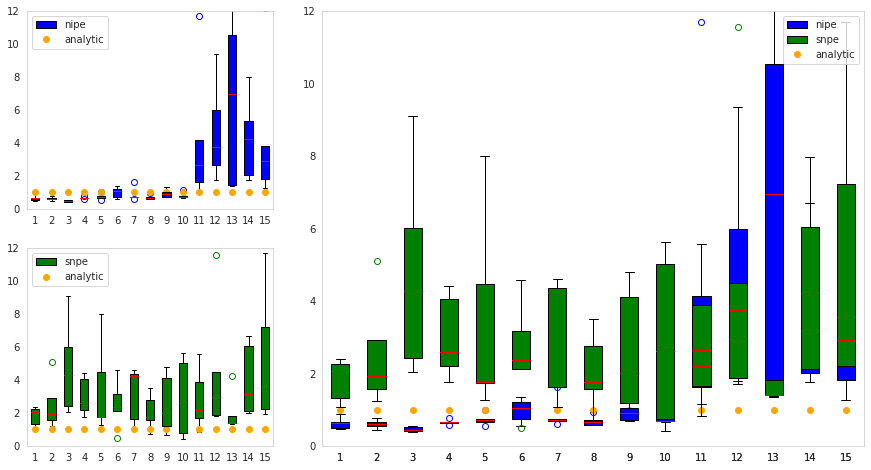

In [33]:
### plot variances:
import seaborn as sns

sns.set_style("whitegrid", {'axes.grid' : False})

figure_mosaic = """
ACC
BCC
"""

fig, axes = plt.subplot_mosaic(mosaic=figure_mosaic, figsize=(15, 8))

#axes['A'].plot(variance_list[58],'o', label='nipe', c='blue')

nipe_box  = axes['A'].boxplot(nipe_array, patch_artist=True, boxprops=dict(facecolor='blue'), medianprops=dict(color='red'),            
            flierprops=dict(color='blue', markeredgecolor='blue'))

axes['A'].set_ylim(0,12)

snpe_box = axes['B'].boxplot(snpe_array, patch_artist=True, boxprops=dict(facecolor='green'), medianprops=dict(color='red'),flierprops=dict(color='green', markeredgecolor='green'),)
axes['B'].set_ylim(0,12)


#axes['A'].plot(variance_list[59],'o', label='nipe', c='blue')
#axes['A'].plot(variance_list[57],'o', label='nipe', c='blue')


axes['C'].boxplot(nipe_array, patch_artist=True, boxprops=dict(facecolor='blue'), medianprops=dict(color='red'), flierprops=dict(color='blue', markeredgecolor='blue'),)

ana_plot = axes['A'].plot(np.linspace(1,15, 15), analytic.stddev[0], 'o', c='orange', label='analytic')
axes['B'].plot(np.linspace(1,15, 15), analytic.stddev[0], 'o', c='orange', label='analytic')
axes['C'].plot(np.linspace(1,15, 15), analytic.stddev[0], 'o', c='orange', label='analytic')

#axes['B'].plot(variance_list_snpe[59],'o', c='g', label = 'snpe')
axes['C'].boxplot(snpe_array, patch_artist=True, boxprops=dict(facecolor='green'), medianprops=dict(color='red'), flierprops=dict(color='green', markeredgecolor='green'),)
axes['C'].set_ylim(0,12)

axes['C'].legend()

axes['B'].legend([snpe_box['boxes'][0], ana_plot[0]], ['snpe', 'analytic'], loc='upper left')
axes['A'].legend([nipe_box['boxes'][0], ana_plot[0]], ['nipe',  'analytic'], loc='upper left')
axes['C'].legend([nipe_box['boxes'][0], snpe_box['boxes'][0], ana_plot[0]], ['nipe', 'snpe', 'analytic'], loc='upper right')

In [17]:
nipe_array = torch.stack(([mean_list[i] for i in range(10)]), dim=1)


snpe_array = torch.stack(([mean_list_snpe[i] for i in range(10)]), dim=1)

In [18]:
analytic.mean

tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])

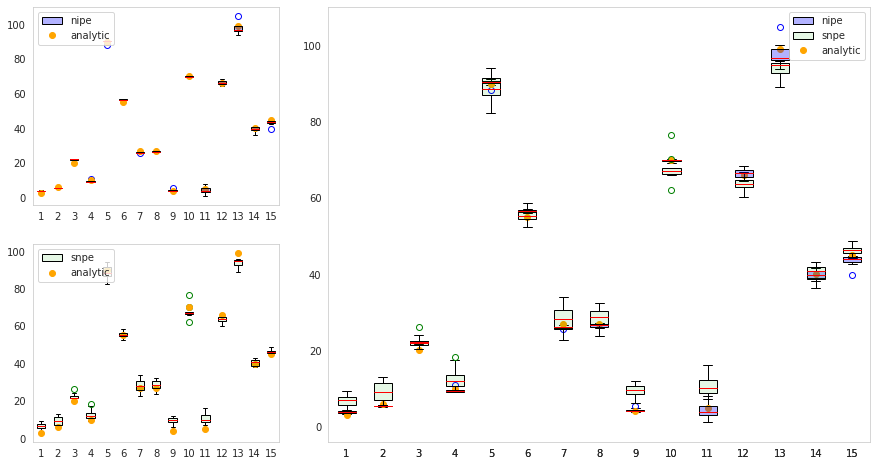

In [19]:
### plot means:
import seaborn as sns

sns.set_style("whitegrid", {'axes.grid' : False})

figure_mosaic = """
ACC
BCC
"""

fig, axes = plt.subplot_mosaic(mosaic=figure_mosaic, figsize=(15, 8))

#axes['A'].plot(variance_list[58],'o', label='nipe', c='blue')

nipe_box  = axes['A'].boxplot(nipe_array, patch_artist=True, boxprops=dict(facecolor='blue'), medianprops=dict(color='red'),            
            flierprops=dict(color='blue', markeredgecolor='blue'))

[patch.set(alpha=None, facecolor=(0.,0.,1,.3)) for patch in nipe_box['boxes']]

#axes['A'].set_ylim(0,15)

snpe_box = axes['B'].boxplot(snpe_array, patch_artist=True, boxprops=dict(facecolor='green'), medianprops=dict(color='red'),flierprops=dict(color='green', markeredgecolor='green'),)
#axes['B'].set_ylim(0,15)

[patch.set(alpha=None, facecolor=(0,0.7,0,.1)) for patch in snpe_box['boxes']]


#axes['A'].plot(variance_list[59],'o', label='nipe', c='blue')
#axes['A'].plot(variance_list[57],'o', label='nipe', c='blue')


nipe_box2 = axes['C'].boxplot(nipe_array, patch_artist=True, boxprops=dict(facecolor='blue'), medianprops=dict(color='red'), flierprops=dict(color='blue', markeredgecolor='blue'),)

ana_plot = axes['A'].plot(np.linspace(1,15, 15), analytic.mean[0], 'o', c='orange', label='analytic')
axes['B'].plot(np.linspace(1,15, 15), analytic.mean[0], 'o', c='orange', label='analytic')
axes['C'].plot(np.linspace(1,15, 15), analytic.mean[0], 'o', c='orange', label='analytic')

#axes['B'].plot(variance_list_snpe[59],'o', c='g', label = 'snpe')
snpe_box2 = axes['C'].boxplot(snpe_array, patch_artist=True, boxprops=dict(facecolor='green'), medianprops=dict(color='red'), flierprops=dict(color='green', markeredgecolor='green'),)
#axes['C'].set_ylim(0,15)

[patch.set(alpha=None, facecolor=(0,0.7,0,.1)) for patch in snpe_box2['boxes']]
[patch.set(alpha=None, facecolor=(0.,0.,1,.3)) for patch in nipe_box2['boxes']]

axes['C'].legend()

axes['B'].legend([snpe_box['boxes'][0], ana_plot[0]], ['snpe', 'analytic'], loc='upper left')
axes['A'].legend([nipe_box['boxes'][0], ana_plot[0]], ['nipe',  'analytic'], loc='upper left')
axes['C'].legend([nipe_box['boxes'][0], snpe_box['boxes'][0], ana_plot[0]], ['nipe', 'snpe', 'analytic'], loc='upper right')

In [88]:
Gaussian(true_thetas[0, 0:])

tensor([  5.6454,   5.7505,  19.2827,   9.4505,  90.3711,  54.3027,  25.7367,
         28.6392,   2.7599,  71.5136,   5.1411,  64.9379, 100.6664,  39.7965,
         43.9925], dtype=torch.float64)

In [38]:
mean_incremental = np.mean(np.array(overall_incremental_list), axis=0)


stdev_incremental = np.std(np.array(overall_incremental_list), axis=0)



lower_incremental = mean_incremental - [element * 0.5 for element in stdev_incremental]

upper_incremental = mean_incremental + [element * 0.5 for element in stdev_incremental]

In [39]:
mean_snpe = np.mean(np.array(overall_snpe_list), axis=0)


stdev_snpe = np.std(np.array(overall_snpe_list), axis=0)


lower_snpe = mean_snpe - [element * 0.5 for element in stdev_snpe]

upper_snpe = mean_snpe + [element * 0.5 for element in stdev_snpe]

In [40]:
num_simulations_list = [500, 750, 1000, 1500, 2000, 3000]

Text(0.5, 0, 'simulations per round')

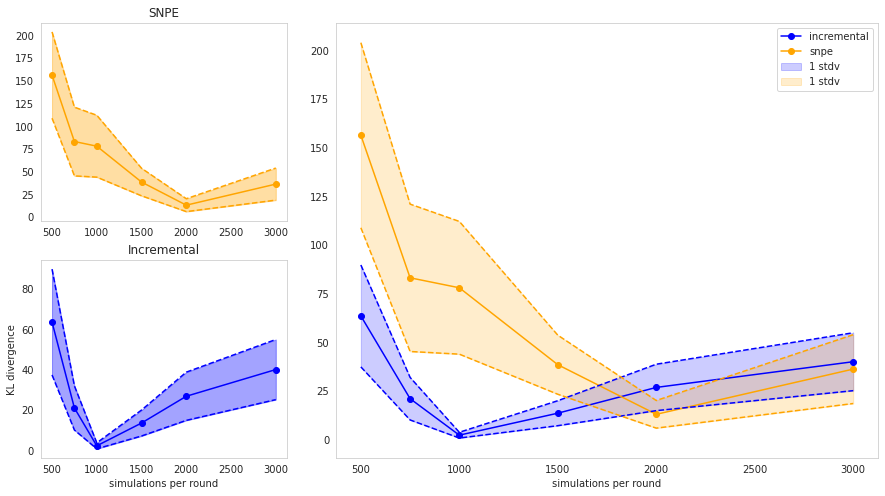

In [41]:
figure_mosaic = """
ACC
BCC
"""

fig, axes = plt.subplot_mosaic(mosaic=figure_mosaic, figsize=(15, 8))

    

axes['B'].plot(num_simulations_list, mean_incremental, '-o', color='blue')
axes['A'].plot(num_simulations_list, mean_snpe, '-o',  color='orange')

axes['B'].plot(num_simulations_list, upper_incremental, '--', color='blue')
axes['A'].plot(num_simulations_list, upper_snpe, '--',  color='orange')

axes['B'].plot(num_simulations_list, lower_incremental, '--', color='blue')
axes['A'].plot(num_simulations_list, lower_snpe, '--',  color='orange')


axes['C'].plot(num_simulations_list, mean_incremental, '-o',label='incremental', color='blue')
axes['C'].plot(num_simulations_list, mean_snpe, '-o', label='snpe', color='orange')

axes['C'].plot(num_simulations_list, upper_incremental, '--', color='blue')
axes['C'].plot(num_simulations_list, upper_snpe, '--',  color='orange')

axes['C'].plot(num_simulations_list, lower_incremental, '--',  color='blue')
axes['C'].plot(num_simulations_list, lower_snpe, '--',  color='orange')


axes['C'].fill_between(x= num_simulations_list, y1=lower_incremental, y2=upper_incremental, color='blue', alpha=0.2,  label='1 stdv')
axes['C'].fill_between(x= num_simulations_list, y1=lower_snpe, y2=upper_snpe, color='orange', alpha=0.2, label='1 stdv')


axes['B'].fill_between(x= num_simulations_list, y1=lower_incremental, y2=upper_incremental, color='blue', alpha=0.2)
axes['A'].fill_between(x= num_simulations_list, y1=lower_snpe, y2=upper_snpe, color='orange', alpha=0.2)


axes['B'].fill_between(x= num_simulations_list, y1=lower_incremental, y2=upper_incremental, color='blue', alpha=0.2)
axes['A'].fill_between(x= num_simulations_list, y1=lower_snpe, y2=upper_snpe, color='orange', alpha=0.2)


#plt.title('KL loss')
#axes['A'].legend()
#axes['B'].legend()
axes['C'].legend()

plt.xlabel('simulations per round')
plt.ylabel('KL divergence')

axes['A'].set_title('SNPE')
axes['B'].set_title('Incremental')

#axes['A'].set_ylim((-5, 120))
#axes['B'].set_ylim((-5, 120))
#axes['C'].set_ylim((-5, 120))

axes['C'].set_xlabel('simulations per round')


#axes['B'].set_xticklabels(['0k','2k', '4k', '6k', '8k', '10k'])
#axes['A'].set_xticklabels(['0k','2k', '4k', '6k', '8k', '10k'])
#axes['C'].set_xticklabels(['0k','2k', '4k', '6k', '8k', '10k'])
#plt.xticks(['1k', '3k', '5k', '10k'])

In [12]:
from sbi.analysis.sbc import check_sbc, run_sbc, get_nltp
from sbi.analysis.plot import sbc_rank_plot
from sbi.inference import SNPE, SNPE_C, prepare_for_sbi, simulate_for_sbi
from sbi.simulators import linear_gaussian, diagonal_linear_gaussian

In [13]:
#thetas = torch.stack(([samples_prior[i] for i in range(len(samples_prior))]))
xs = samples_prior

In [14]:
xs.shape

torch.Size([10000, 15])

In [15]:
posterior = list_collection_inc[0][0]

In [16]:
posterior_samples = posterior.sample((10,))


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

In [17]:
for idx, (tho, xo) in enumerate(zip(thetas, xs)):
    print(tho.shape)

torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15

torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15

torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15

torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15

In [18]:
# run SBC: for each inference we draw 1000 posterior samples.
num_posterior_samples = 300
ranks, dap_samples = run_sbc(thetas, xs, posterior, num_posterior_samples=num_posterior_samples)

Running 10000 sbc samples.:   0%|          | 0/10000 [00:00<?, ?it/s]

TypeError: sample() got an unexpected keyword argument 'context'

In [ ]:
check_stats = check_sbc(ranks, thetas, dap_samples, num_posterior_samples=num_posterior_samples)


print(f"kolmogorov-smirnov p-values \ncheck_stats['ks_pvals'] = {check_stats['ks_pvals'].numpy()}")

In [2]:
print(f"c2st accuracies \ncheck_stats['c2st_ranks'] = {check_stats['c2st_ranks'].numpy()}")
print(f"- c2st accuracies check_stats['c2st_dap'] = {check_stats['c2st_dap'].numpy()}")


NameError: name 'check_stats' is not defined

In [3]:
from sbi.analysis.plot import sbc_rank_plot

f, ax = sbc_rank_plot(ranks=ranks,
                      num_posterior_samples=num_posterior_samples,
                      plot_type="hist",
                      num_bins=10 # by passing None we use a heuristic for the number of bins.
                      )

NameError: name 'ranks' is not defined

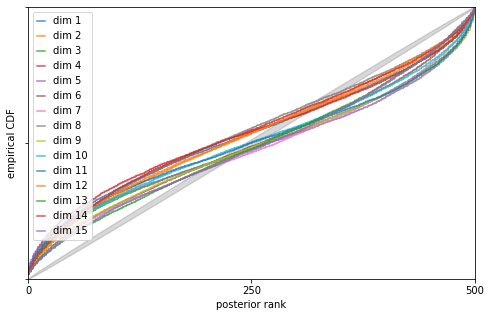

In [54]:
f, ax = sbc_rank_plot(ranks, 1_000, plot_type = "cdf")